### Necessary Imports

In [4]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath(os.path.join('..', '..', 'models', 'AutoEncoders')))
from cnn_autoencoder import CNNAutoencoder


import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Loading and splitting the Fashion MNIST dataset

In [ ]:
base_path = '../../data/external/fashion_mnist'
train_path = f'{base_path}/fashion-mnist_train.csv'
test_path = f'{base_path}/fashion-mnist_test.csv'
output_path = '../../data/interim/4/fashion_mnist'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df_split = train_df[:50000]
val_df_split = train_df[50000:]

train_df_split.to_csv(f'{output_path}/fashion-mnist_train.csv', index=False)
val_df_split.to_csv(f'{output_path}/fashion-mnist_val.csv', index=False)
test_df.to_csv(f'{output_path}/fashion-mnist_test.csv', index=False)

print("Data shuffled, split, and saved successfully.")


#### Visualizing images from the dataset to see different kinds of clothings and the labels assigned to them

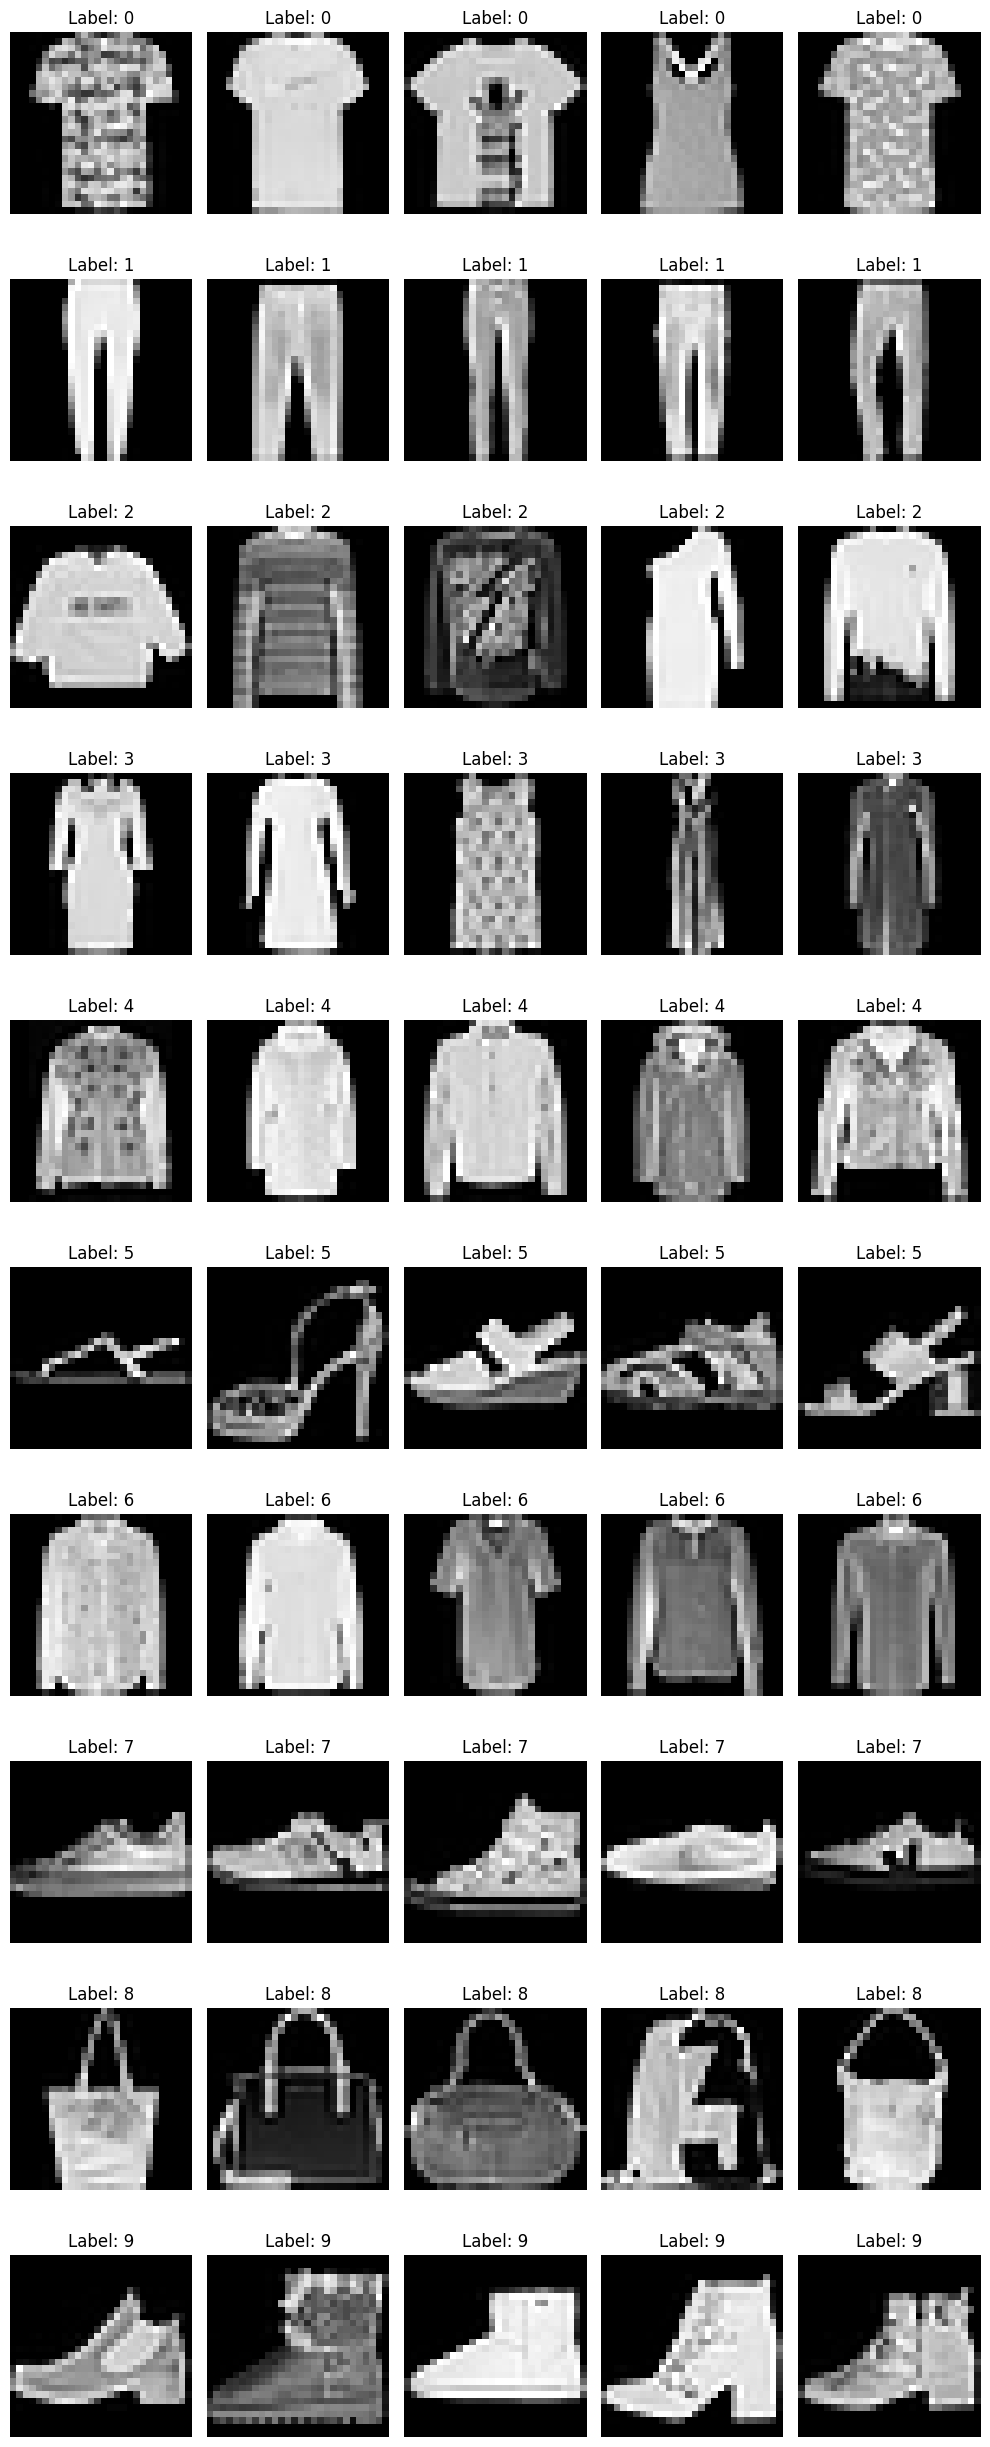

In [6]:
num_labels = 10 
fig, axes = plt.subplots(num_labels, 5, figsize=(10, num_labels * 2.5))

for label in range(num_labels):
    images = train_df[train_df.iloc[:, 0] == label].iloc[:, 1:].values[:5] 
    for j, image in enumerate(images):
        image_reshaped = image.reshape(28, 28)
        axes[label, j].imshow(image_reshaped, cmap='gray')
        axes[label, j].set_title(f'Label: {label}')
        axes[label, j].axis('off')
plt.tight_layout()
plt.show()

#### Listing the clothing type represented by each class

0. **T-shirt**

1. **Trousers**

2. **Sweater**: This looks like warm clothing, mostly without a zipper.

3. **Dress**

4. **Jackets**: This looks like warm clothing, with what seems like zippers in most cases.

5. **Sandals**: The images shows open footwear, like heels and wedges.

6. **Shirts/Polos**: This looks like a collared shirt with buttons down the front.

7. **Sneakers**: These appear to be athletic shoes.

8. **Bag**: These resemble purses or handbags.

9. **Boots**: These look like footwear but are higher than the sneakers.

### Loading the data

In [ ]:
base_path = '../../data/interim/4/fashion_mnist'
train_path = f'{base_path}/fashion-mnist_train.csv'
val_path = f'{base_path}/fashion-mnist_val.csv'
test_path = f'{base_path}/fashion-mnist_test.csv'

def load_fashion_data():
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)

    X_train = train_df.iloc[:, 1:].values.astype('float32') / 255.0 
    y_train = train_df.iloc[:, 0].values  
    
    X_val = val_df.iloc[:, 1:].values.astype('float32') / 255.0 
    y_val = val_df.iloc[:, 0].values  
    
    X_test = test_df.iloc[:, 1:].values.astype('float32') / 255.0 
    y_test = test_df.iloc[:, 0].values  
    
    return (train_df, val_df, test_df), (X_train, y_train, X_val, y_val, X_test, y_test)

class MultiMNISTDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        label = self.dataframe.iloc[idx, 0]
        image = self.dataframe.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)  
        image = Image.fromarray(image)  
        if self.transform:
            image = self.transform(image)
        
        return image, label

(dataframes, (X_train, y_train, X_val, y_val, X_test, y_test)) = load_fashion_data()

transform = transforms.Compose([
    transforms.ToTensor(), 
])

batch_size = 64
train_dataset = MultiMNISTDataset(dataframes[0], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MultiMNISTDataset(dataframes[1], transform=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = MultiMNISTDataset(dataframes[2], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Implementing the CnnAutoencoder class

In [8]:
model = CNNAutoencoder(device=device).to(device)
model.fit(train_loader, num_epochs=10, learning_rate=0.001)
model.evaluate(test_loader)

Epoch [1/10]: 100%|██████████| 782/782 [00:17<00:00, 45.57batch/s]


Epoch [1/10], Loss: 0.0284


Epoch [2/10]: 100%|██████████| 782/782 [00:17<00:00, 43.67batch/s]


Epoch [2/10], Loss: 0.0121


Epoch [3/10]: 100%|██████████| 782/782 [00:13<00:00, 56.68batch/s]


Epoch [3/10], Loss: 0.0098


Epoch [4/10]: 100%|██████████| 782/782 [00:18<00:00, 42.91batch/s]


Epoch [4/10], Loss: 0.0086


Epoch [5/10]: 100%|██████████| 782/782 [00:15<00:00, 49.84batch/s]


Epoch [5/10], Loss: 0.0079


Epoch [6/10]: 100%|██████████| 782/782 [00:15<00:00, 49.10batch/s]


Epoch [6/10], Loss: 0.0073


Epoch [7/10]: 100%|██████████| 782/782 [00:19<00:00, 40.89batch/s]


Epoch [7/10], Loss: 0.0070


Epoch [8/10]: 100%|██████████| 782/782 [00:15<00:00, 49.37batch/s]


Epoch [8/10], Loss: 0.0067


Epoch [9/10]: 100%|██████████| 782/782 [00:16<00:00, 46.71batch/s]


Epoch [9/10], Loss: 0.0065


Epoch [10/10]: 100%|██████████| 782/782 [00:18<00:00, 41.71batch/s]


Epoch [10/10], Loss: 0.0063


Evaluating: 100%|██████████| 157/157 [00:02<00:00, 78.43batch/s]

Test Loss: 0.0064


0.006363664563000202

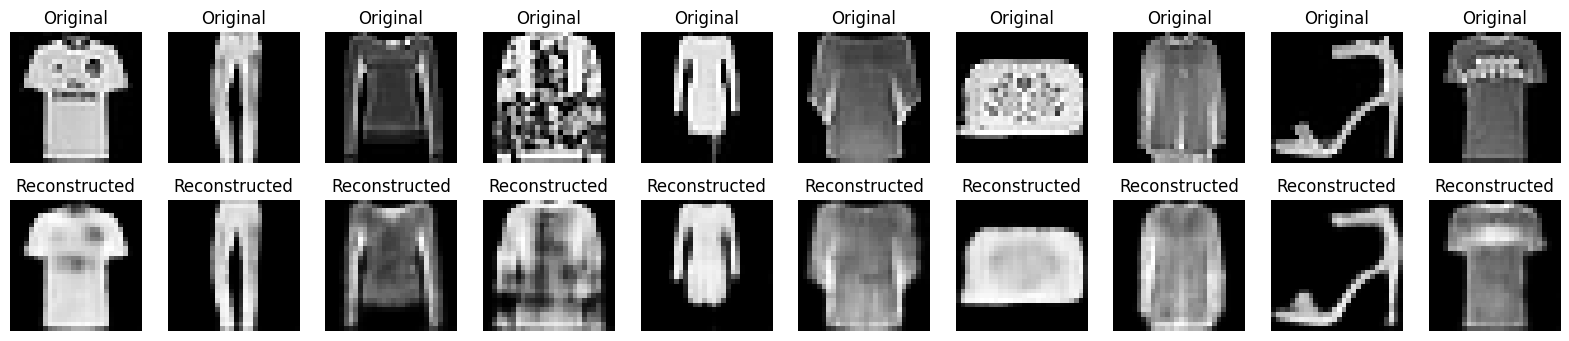

In [9]:
import matplotlib.pyplot as plt

def show_reconstructed_images(model, data_loader, num_images=10):
    model.eval()
    
    data_iter = iter(data_loader)
    images, _ = next(data_iter)
    images = images[:num_images]  
    images = images.to(device)
    
    with torch.no_grad():
        reconstructed = model(images)

    images = images.cpu()
    reconstructed = reconstructed.cpu()
    
    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
    for i in range(num_images):
        axes[0, i].imshow(images[i].squeeze(), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')
        axes[1, i].imshow(reconstructed[i].squeeze(), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    
    plt.show()

show_reconstructed_images(model, test_loader, num_images=10)


#### Autoencoder Output Quality:
The reconstructed images show good preservation of basic clothing shapes and silhouettes while losing finer details. Essential structural elements like collars, sleeves, and pant legs remain identifiable, but text patterns and textures are notably smoothed out. This level of reconstruction is sufficient for distinguishing clothing categories while demonstrating expected information compression in the latent space.

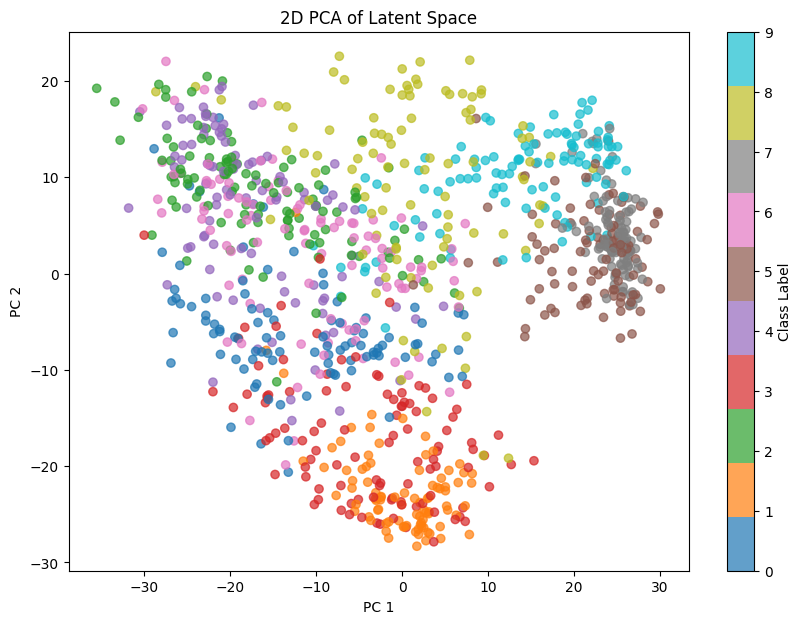

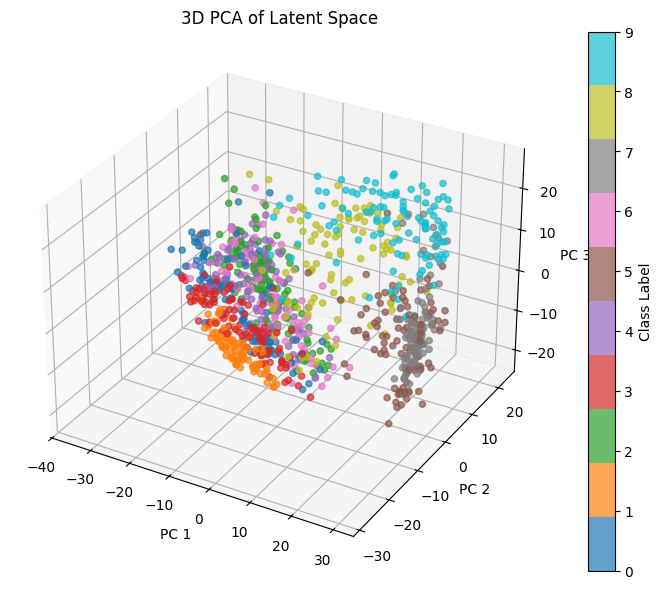

In [10]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def plot_latent_space(model, data_loader, num_samples=1000):
    model.eval()
    latent_representations = []
    labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            encoded = model.encode(x)
            latent_representations.append(encoded.view(encoded.size(0), -1).cpu().numpy())
            labels.extend(y.cpu().numpy())
            if len(labels) >= num_samples:
                break
    
    latent_representations = np.concatenate(latent_representations)[:num_samples]
    labels = np.array(labels)[:num_samples]
    
    pca_2d = PCA(n_components=2)
    latent_2d = pca_2d.fit_transform(latent_representations)
    
    pca_3d = PCA(n_components=3)
    latent_3d = pca_3d.fit_transform(latent_representations)

    # 2D plot
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Class Label')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title("2D PCA of Latent Space")
    plt.show()

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=labels, cmap='tab10', alpha=0.7)
    fig.colorbar(scatter, ax=ax, label='Class Label')
    ax.set_xlabel("PC 1")
    ax.set_ylabel("PC 2")
    ax.set_zlabel("PC 3")
    plt.title("3D PCA of Latent Space")
    plt.show()

plot_latent_space(model, test_loader)


### Latent Space Analysis:

The PCA visualizations indicate notable clustering of fashion items:

- Footwear items, such as Sandals, Boots and Sneakers, are grouped closely, reflecting their functional similarities.Sandls and Sneakers have overlaps in the 3D space.
- Full-body garments like Jackets and Sweaters are also positioned near each other.
- Bags are distinctly clustered.
- A clear clustering can be seen between clothing items, footwear and bgs.
- There is a proximity between Trousers and Dresses, possibly due to both being full-length items, but th clusters are distinct enough.

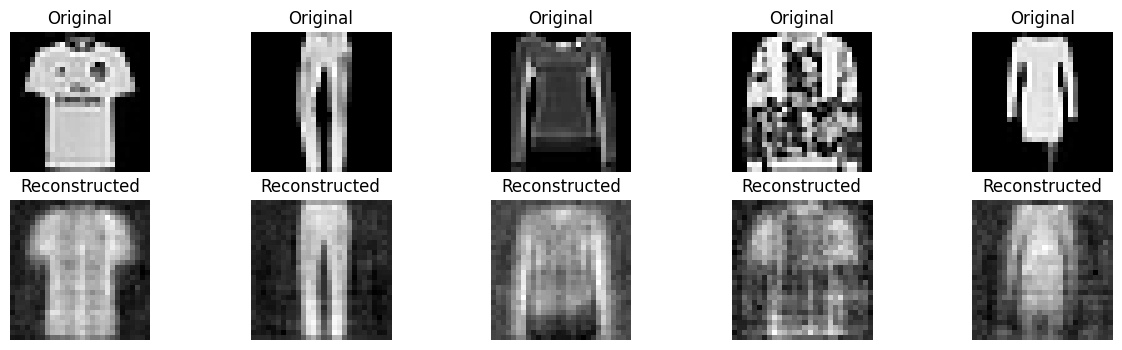

In [17]:
# from AutoEncoders import AutoEncoder


# input_size = 28*28
# latent_size = 75
# encoder_layers = []  
# decoder_layers = []  
# learning_rate = 0.08
# max_epochs = 50
# batch_size = 32

# autoencoder = AutoEncoder(
#     input_size=input_size,
#     latent_size=latent_size,
#     encoder_layers=encoder_layers,
#     decoder_layers=decoder_layers,
#     learning_rate=learning_rate,
#     optimizer='mbgd'
# )
# print(X_train.shape)
# autoencoder.fit(X_train, max_epochs=max_epochs, batch_size=batch_size)
# X_reconstructed = autoencoder.reconstruct(X_train)

import matplotlib.pyplot as plt
def visualize_reconstruction(autoencoder, X_test, n_images=5):
    X_reconstructed = autoencoder.reconstruct(X_test[:n_images])

    fig, axes = plt.subplots(2, n_images, figsize=(15, 4))
    for i in range(n_images):
        axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

visualize_reconstruction(mlp_autoencoder_knn, X_test)

In [ ]:
print(X_train[0])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pca_autoencoder import PcaAutoencoder

def plot_construction_loss(X_train, max_components=20):
    errors = []
    for n in range(1, max_components + 1):
        pca_autoencoder = PcaAutoencoder(n_components=n)
        pca_autoencoder.fit(X_train)
        error = pca_autoencoder.reconstruction_error(X_train)
        errors.append(error)

    plt.plot(range(1, max_components + 1), errors, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Reconstruction Error')
    plt.title('Reconstruction Error vs Number of Components')
    plt.grid(True)
    plt.show()
    return errors

errors = plot_construction_loss(X_train)


In [ ]:

pca_autoencoder = PcaAutoencoder(n_components=75)
pca_autoencoder.fit(X_train)

def visualize_reconstruction(autoencoder, X_test, n_images=5):
    X_reconstructed = autoencoder.forward(X_test[:n_images])

    fig, axes = plt.subplots(2, n_images, figsize=(15, 4))
    for i in range(n_images):
        axes[0, i].imshow(X_test[i].reshape(28, 28), cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        axes[1, i].imshow(X_reconstructed[i].reshape(28, 28), cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
    plt.show()

visualize_reconstruction(pca_autoencoder, X_val)

#### KNN Classification

In [4]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', 'models', 'knn')))
sys.path.append(os.path.abspath(os.path.join('..', '..', 'performance_measures')))
from knn import KNN
from classification_metrics import Metrics

In [5]:
from pca_autoencoder import PcaAutoencoder
pca_autoencoder_knn = PcaAutoencoder(n_components=64)
pca_autoencoder_knn.fit(X_train)

X_train_encoded_pca = pca_autoencoder_knn.encode(X_train)
X_test_encoded_pca = pca_autoencoder_knn.encode(X_test)

In [6]:
knn_pca = KNN(k=5, distance_metric='cosine')
knn_pca.fit(X_train_encoded_pca, y_train)
y_pred_pca_1 = knn_pca.predict(X_test_encoded_pca[:5000])
y_pred_pca_2 = knn_pca.predict(X_test_encoded_pca[5000:])
scores_pca = Metrics(y_test, np.concatenate((y_pred_pca_1,y_pred_pca_2)), task='classification')
accuracy_pca = scores_pca.accuracy()
print(f"Accuracy of KNN with PCA: {accuracy_pca:.5f}")

Accuracy of KNN with PCA: 0.86310


In [38]:
from AutoEncoders import AutoEncoder


input_size = 28*28
latent_size = 75
encoder_layers = []  
decoder_layers = []  
learning_rate = 0.01
max_epochs = 20
batch_size = 32

mlp_autoencoder_knn = AutoEncoder(
    input_size=input_size,
    latent_size=latent_size,
    encoder_layers=encoder_layers,
    decoder_layers=decoder_layers,
    learning_rate=learning_rate,
    optimizer='sgd'
)
print(X_train.shape)
mlp_autoencoder_knn.fit(X_train, max_epochs=max_epochs, batch_size=batch_size)
X_train_encoded_mlp = mlp_autoencoder_knn.get_latent(X_train)
X_test_encoded_mlp = mlp_autoencoder_knn.get_latent(X_test)

(50000, 784)
Epoch 1/20, Loss: 0.03527552569864907
Epoch 2/20, Loss: 0.020954353880839247
Epoch 3/20, Loss: 0.018760958442633813
Epoch 4/20, Loss: 0.017960207499644255
Epoch 5/20, Loss: 0.01759598351781362
Epoch 6/20, Loss: 0.017412964551129066
Epoch 7/20, Loss: 0.017316237118311067
Epoch 8/20, Loss: 0.017260665126982013
Epoch 9/20, Loss: 0.017229339568043657
Epoch 10/20, Loss: 0.017210066472636353
Epoch 11/20, Loss: 0.01719583941098912
Epoch 12/20, Loss: 0.017189918650713475
Epoch 13/20, Loss: 0.017185335510811434
Epoch 14/20, Loss: 0.017184096331290248
Epoch 15/20, Loss: 0.017180737974069386
Epoch 16/20, Loss: 0.017177516093531707
Epoch 17/20, Loss: 0.017178746523859197
Epoch 18/20, Loss: 0.01717828671556896
Epoch 19/20, Loss: 0.01717666472649562
Epoch 20/20, Loss: 0.01717654615754755


In [37]:
knn_mlp = KNN(k=5, distance_metric='cosine')
knn_mlp.fit(X_train_encoded_mlp, y_train)
y_pred_mlp_1 = knn_mlp.predict(X_test_encoded_mlp[:5000])
y_pred_mlp_2 = knn_mlp.predict(X_test_encoded_mlp[5000:])
scores_mlp = Metrics(y_test, np.concatenate((y_pred_mlp_1,y_pred_mlp_2)), task='classification')
accuracy_mlp = scores_mlp.accuracy()
print(f"Accuracy of KNN with MLP: {accuracy_mlp:.5f}")

Accuracy of KNN with MLP: 0.84620
